In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import numpy as np

In [4]:
# Establish a connection to the SQLite database
conn = sqlite3.connect('Data/users_data.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Query to retrieve table names from the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all the table names
table_names = cursor.fetchall()

# Print the table names
for name in table_names:
    print(name[0])

Users


In [5]:
# Read data from the database into a DataFrame
users = pd.read_sql('SELECT * FROM Users', conn)

# Close the cursor and connection
cursor.close()
conn.close()

In [6]:
users.head(3)

,id,username,age,gender,fav_entertainment,least_fav_entertainment,likes,dislikes,movie_watching_freq,show_watching_freq,reading_freq
0,1,Krystal9132,22,F,"Movies, Tv-shows",Books,History,"Thriller, Documentary",Daily,Daily,Never
1,2,Rita4030,31,F,"Tv-shows, Movies",None,"Classics, Documentary",Comedy,Daily,Rarely,Rarely
2,3,Jacqueline534,68,M,"Movies, Books",Tv-shows,"Animation, Adventure, Sci-Fi","Documentary, Drama, Classics, Thriller, Action",Daily,Rarely,Monthly


In [7]:
users_encoded = users

In [8]:
users_encoded = users_encoded.drop(columns=['id', 'username'])

In [9]:
users_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   age                      10000 non-null  int64 
 1   gender                   10000 non-null  object
 2   fav_entertainment        10000 non-null  object
 3   least_fav_entertainment  10000 non-null  object
 4   likes                    10000 non-null  object
 5   dislikes                 10000 non-null  object
 6   movie_watching_freq      10000 non-null  object
 7   show_watching_freq       10000 non-null  object
 8   reading_freq             10000 non-null  object
dtypes: int64(1), object(8)
memory usage: 703.3+ KB


In [10]:
def convert_to_binary(value):
    if value == 'F':
        return 0
    elif value == 'M':
        return 1
    else:
        return np.nan

In [11]:
users_encoded['gender'] = users_encoded['gender'].apply(lambda x: convert_to_binary(x))


In [12]:
users_encoded

,age,gender,fav_entertainment,least_fav_entertainment,likes,dislikes,movie_watching_freq,show_watching_freq,reading_freq
0,22,0,"Movies, Tv-shows",Books,History,"Thriller, Documentary",Daily,Daily,Never
1,31,0,"Tv-shows, Movies",None,"Classics, Documentary",Comedy,Daily,Rarely,Rarely
2,68,1,"Movies, Books",Tv-shows,"Animation, Adventure, Sci-Fi","Documentary, Drama, Classics, Thriller, Action",Daily,Rarely,Monthly
3,46,1,Books,Tv-shows,"Classics, History, Action, Sci-Fi, Fantasy","Documentary, Action, History",Rarely,Monthly,Monthly
4,36,1,"Books, Movies",Tv-shows,"Classics, Comedy",Comedy,Weekly,Never,Daily
...,...,...,...,...,...,...,...,...,...
9995,64,0,Tv-shows,None,"Sci-Fi, Horror, Mystery, Documentary, Animation","Fiction, Mystery, Classics, Comedy, Horror",Monthly,Weekly,Daily
9996,59,1,Tv-shows,Movies,"Comedy, Mystery, Fantasy, Drama","Fantasy, Romance, Sci-Fi, Animation, Action",Monthly,Never,Rarely
9997,71,0,"Books, Movies",None,"Drama, Horror, Classics","Fantasy, Romance, Comedy",Weekly,Daily,Daily
9998,38,0,Movies,Books,"Thriller, Mystery, Action, Documentary","Mystery, Action, History",Rarely,Monthly,Daily


In [13]:
# Preprocess the columns to standardize the combinations
users_encoded['fav_entertainment'] = users_encoded['fav_entertainment'].apply(lambda x: ', '.join(sorted(x.split(', '))))
users_encoded['least_fav_entertainment'] = users_encoded['least_fav_entertainment'].apply(lambda x: ', '.join(sorted(x.split(', '))))

# One-hot encode 'fav_entertainment' column
fav_encoded = users_encoded['fav_entertainment'].str.get_dummies(', ').add_prefix('fav_')

# One-hot encode 'least_fav_entertainment' column
least_fav_encoded = users_encoded['least_fav_entertainment'].str.get_dummies(', ').add_prefix('least_fav_')

# Concatenate the new one-hot encoded columns with the original DataFrame
users_encoded = pd.concat([users_encoded, fav_encoded, least_fav_encoded], axis=1)

# Drop the original columns if needed
users_encoded.drop(['fav_entertainment', 'least_fav_entertainment'], axis=1, inplace=True)

In [14]:
# Preprocess the columns to standardize the combinations
users_encoded['likes'] = users_encoded['likes'].apply(lambda x: ', '.join(sorted(x.split(', '))))
users_encoded['dislikes'] = users_encoded['dislikes'].apply(lambda x: ', '.join(sorted(x.split(', '))))

# One-hot encode 'likes' column
likes_encoded = users_encoded['likes'].str.get_dummies(', ').add_prefix('likes_')

# One-hot encode 'dislikes' column
dislikes_encoded = users_encoded['dislikes'].str.get_dummies(', ').add_prefix('dislikes_')

# Concatenate the new one-hot encoded columns with the original DataFrame
users_encoded = pd.concat([users_encoded, likes_encoded, dislikes_encoded], axis=1)

# Drop the original columns if needed
users_encoded.drop(['likes', 'dislikes'], axis=1, inplace=True)

In [15]:
# Define the encoding map
encoding_map = {'Never': 0, 'Rarely': 1, 'Monthly': 2, 'Weekly': 3, 'Daily': 4}

# Apply the mapping to encode the variables in users_encoded
users_encoded['movie_watching_freq'] = users_encoded['movie_watching_freq'].map(encoding_map)
users_encoded['show_watching_freq'] = users_encoded['show_watching_freq'].map(encoding_map)
users_encoded['reading_freq'] = users_encoded['reading_freq'].map(encoding_map)

In [16]:
users_encoded

,age,gender,movie_watching_freq,show_watching_freq,reading_freq,fav_Books,fav_Movies,fav_Tv-shows,least_fav_Books,least_fav_Movies,...,dislikes_Documentary,dislikes_Drama,dislikes_Fantasy,dislikes_Fiction,dislikes_History,dislikes_Horror,dislikes_Mystery,dislikes_Romance,dislikes_Sci-Fi,dislikes_Thriller
0,22,0,4,4,0,0,1,1,1,0,...,1,0,0,0,0,0,0,0,0,1
1,31,0,4,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68,1,4,1,2,1,1,0,0,0,...,1,1,0,0,0,0,0,0,0,1
3,46,1,1,2,2,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,36,1,3,0,4,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,64,0,2,3,4,0,0,1,0,0,...,0,0,0,1,0,1,1,0,0,0
9996,59,1,2,0,1,0,0,1,0,1,...,0,0,1,0,0,0,0,1,1,0
9997,71,0,3,4,4,1,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
9998,38,0,1,2,4,0,1,0,1,0,...,0,0,0,0,1,0,1,0,0,0


In [17]:
users_encoded.columns

Index(['age', 'gender', 'movie_watching_freq', 'show_watching_freq',
       'reading_freq', 'fav_Books', 'fav_Movies', 'fav_Tv-shows',
       'least_fav_Books', 'least_fav_Movies', 'least_fav_None',
       'least_fav_Tv-shows', 'likes_Action', 'likes_Adventure',
       'likes_Animation', 'likes_Classics', 'likes_Comedy',
       'likes_Documentary', 'likes_Drama', 'likes_Fantasy', 'likes_Fiction',
       'likes_History', 'likes_Horror', 'likes_Mystery', 'likes_Romance',
       'likes_Sci-Fi', 'likes_Thriller', 'dislikes_Action',
       'dislikes_Adventure', 'dislikes_Animation', 'dislikes_Classics',
       'dislikes_Comedy', 'dislikes_Documentary', 'dislikes_Drama',
       'dislikes_Fantasy', 'dislikes_Fiction', 'dislikes_History',
       'dislikes_Horror', 'dislikes_Mystery', 'dislikes_Romance',
       'dislikes_Sci-Fi', 'dislikes_Thriller'],
      dtype='object')

In [18]:
%pip install phik

Note: you may need to restart the kernel to use updated packages.


In [19]:
%pip install seaborn

In [20]:
from phik import phik_matrix
import seaborn as sns

interval columns not set, guessing: ['likes_Action', 'likes_Adventure', 'likes_Animation', 'likes_Classics', 'likes_Comedy', 'likes_Documentary', 'likes_Drama', 'likes_Fantasy', 'likes_Fiction', 'likes_History', 'likes_Horror', 'likes_Mystery', 'likes_Romance', 'likes_Sci-Fi', 'likes_Thriller', 'dislikes_Action', 'dislikes_Adventure', 'dislikes_Animation', 'dislikes_Classics', 'dislikes_Comedy', 'dislikes_Documentary', 'dislikes_Drama', 'dislikes_Fantasy', 'dislikes_Fiction', 'dislikes_History', 'dislikes_Horror', 'dislikes_Mystery', 'dislikes_Romance', 'dislikes_Sci-Fi', 'dislikes_Thriller']


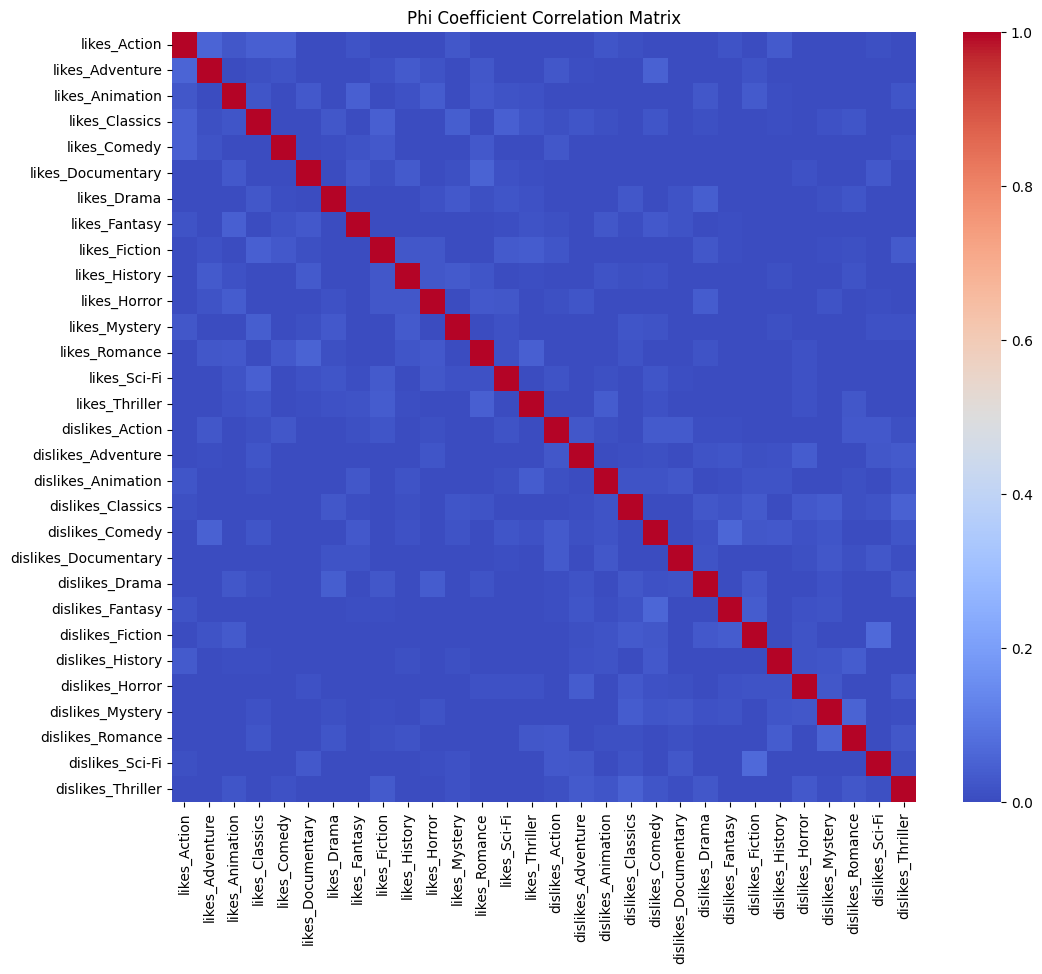

In [21]:
# Extract the subset of your DataFrame with the selected columns
subset_users_encoded = users_encoded.drop(columns=['age', 'gender', 'movie_watching_freq', 'show_watching_freq',
       'reading_freq', 'fav_Books', 'fav_Movies', 'fav_Tv-shows',
       'least_fav_Books', 'least_fav_Movies', 'least_fav_None',
       'least_fav_Tv-shows'])

# Calculate the Phi Coefficient matrix
phi_matrix = phik_matrix(subset_users_encoded)

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(phi_matrix, cmap='coolwarm')
plt.title('Phi Coefficient Correlation Matrix')
plt.show()

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
data_clustering = users_encoded

In [24]:
feat_scaler = MinMaxScaler()
data_scaled = feat_scaler.fit_transform(data_clustering)

In [25]:
dispersion = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_scaled)
    dispersion.append(kmeans.inertia_)

c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packa

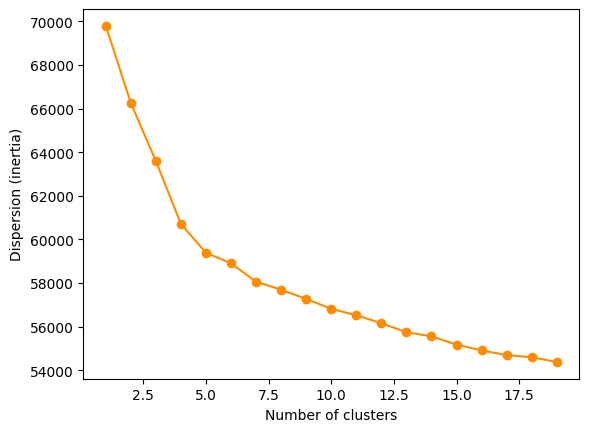

In [26]:
plt.plot(range(1, 20), dispersion, marker='o', color='darkorange')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.show()

In [27]:
from sklearn.metrics import silhouette_score

def compute_silhouette_scores(data, range_n_clusters):
    silhouette_scores = []

    for n_clusters in range_n_clusters:
        # Initialize KMeans with n_clusters and fit the data
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(data)
        
        # Compute the silhouette score for the current clustering
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    return silhouette_scores

In [28]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
silhouette_scores = compute_silhouette_scores(data_scaled, range_n_clusters)
print(silhouette_scores)

c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packa

[0.05131536891084418, 0.05782057545753101, 0.060347883514262346, 0.06703147497107523, 0.057469584452637695, 0.05155195196369893, 0.04687362836207342, 0.04097225672697425, 0.04167503851186345, 0.04034048640951986, 0.043777967591559046, 0.03951889540035625, 0.03857064638038887]


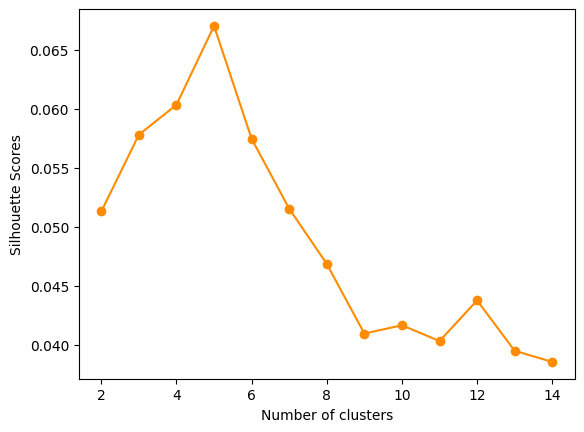

In [29]:
plt.plot(range(2, 15), silhouette_scores, marker='o', color='darkorange')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Scores')
plt.show()

Initialy tried with 5 clusters as suggested by the plots of dispersion and silhouette scores, but 4 worked better, we analyze that later in the t-SNE and UMAP visualizations.

In [50]:
kmeans_solution = KMeans(n_clusters=4, random_state=42).fit(data_scaled)
cluster_labels = kmeans_solution.predict(data_scaled)
cluster_labels += 1  # Add 1 to shift the labels from 0-3 to 1-4
data_clustering['cluster'] = cluster_labels

c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


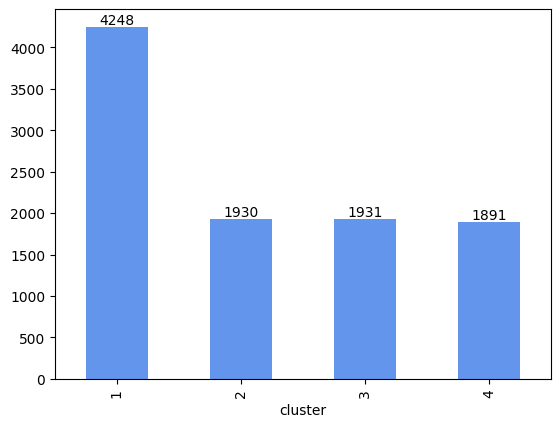

In [51]:
# Group the data by 'cluster' and calculate the size of each group
cluster_counts = data_clustering.groupby('cluster').size()

# Create the bar plot
ax = cluster_counts.plot(kind='bar', color='cornflowerblue')

# Add text annotations above each bar
for i, count in enumerate(cluster_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

# Display the plot
plt.show()

In [52]:
from sklearn.manifold import TSNE

In [53]:
cluster_kmeans = data_clustering['cluster']

In [43]:
tsne_model_ = TSNE(n_components=2, perplexity=500, random_state=42)
tsne_cust = tsne_model_.fit_transform(data_scaled)

In [44]:
def visualize_dimensionality_reduction(data, labels):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    plt.title('Dimensionality Reduction Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar(label='Cluster')
    plt.show()

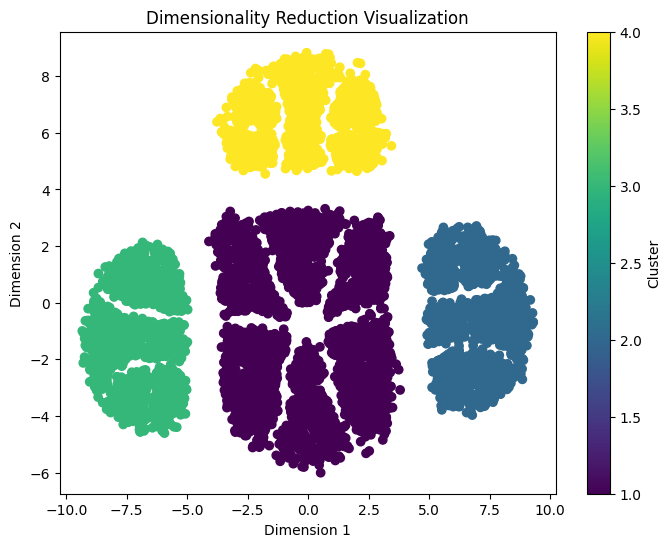

In [36]:
visualize_dimensionality_reduction(tsne_cust, np.array(cluster_kmeans))

In [131]:
%pip install umap

Note: you may need to restart the kernel to use updated packages.


In [1]:
import umap

c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import umap.umap_ as umap

In [46]:
umap_object = umap.UMAP(n_neighbors=300, min_dist=0.8, random_state=42)

In [47]:
%%time
umap_embedding = umap_object.fit_transform(data_scaled)

c:\Users\Ultilizador\Documents\GitHub\Capstone-Project\env\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


CPU times: total: 1min 54s
Wall time: 1min 25s


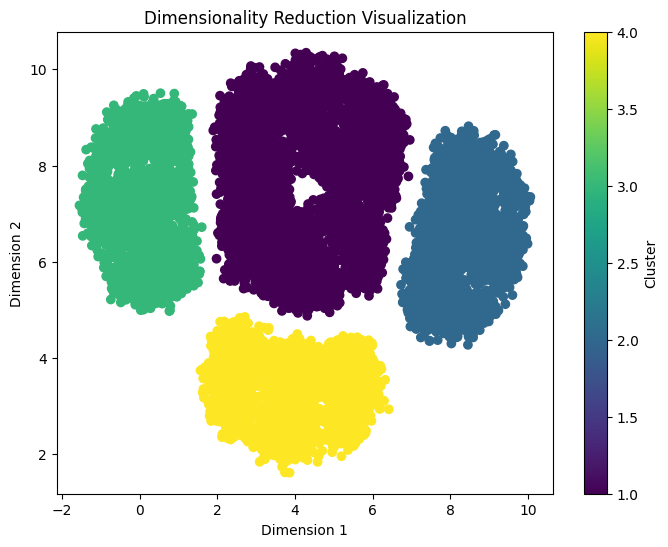

In [39]:
# create a scatter plot of the UMAP output
visualize_dimensionality_reduction(umap_embedding, np.array(cluster_kmeans))

In [67]:
data_clustering.columns

Index(['age', 'gender', 'movie_watching_freq', 'show_watching_freq',
       'reading_freq', 'fav_Books', 'fav_Movies', 'fav_Tv-shows',
       'least_fav_Books', 'least_fav_Movies', 'least_fav_None',
       'least_fav_Tv-shows', 'likes_Action', 'likes_Adventure',
       'likes_Animation', 'likes_Classics', 'likes_Comedy',
       'likes_Documentary', 'likes_Drama', 'likes_Fantasy', 'likes_Fiction',
       'likes_History', 'likes_Horror', 'likes_Mystery', 'likes_Romance',
       'likes_Sci-Fi', 'likes_Thriller', 'dislikes_Action',
       'dislikes_Adventure', 'dislikes_Animation', 'dislikes_Classics',
       'dislikes_Comedy', 'dislikes_Documentary', 'dislikes_Drama',
       'dislikes_Fantasy', 'dislikes_Fiction', 'dislikes_History',
       'dislikes_Horror', 'dislikes_Mystery', 'dislikes_Romance',
       'dislikes_Sci-Fi', 'dislikes_Thriller', 'cluster'],
      dtype='object')

In [66]:
# Group by 'cluster' and calculate descriptive statistics for each feature
grouped_stats = data_clustering.groupby('cluster').agg({
    'age': 'mean',  # Example: mean age by cluster
    'gender': 'mean',  # Example: mean gender by cluster
    'movie_watching_freq': lambda x: x.mode().iloc[0],  # Frequencies of movie_watching_freq by cluster
    'show_watching_freq': lambda x: x.mode().iloc[0],  # Frequencies of show_watching_freq by cluster
    'reading_freq': lambda x: x.mode().iloc[0],  # Frequencies of reading_freq by cluster
    
    # Add similar lambda functions for other binary variables
})

# Creating a DataFrame from the computed statistics
db_clusters_df = pd.DataFrame(grouped_stats)

# Displaying the resulting dataset
db_clusters_df.T

cluster,1,2,3,4
age,49.536723,50.133679,48.943035,49.647277
gender,0.505414,0.510363,0.518902,0.522475
movie_watching_freq,2.000000,4.000000,0.000000,2.000000
show_watching_freq,3.000000,3.000000,1.000000,3.000000
reading_freq,1.000000,2.000000,3.000000,2.000000


In [68]:
# Group by 'cluster' and calculate descriptive statistics for each feature
grouped_stats = data_clustering.groupby('cluster').agg({
    'age': 'mean',
    'gender': 'mean',
    'movie_watching_freq': 'mean',
    'show_watching_freq': 'mean',
    'reading_freq': 'mean',
    'fav_Books': 'mean',
    'fav_Movies': 'mean',
    'fav_Tv-shows': 'mean',
    'least_fav_Books': 'mean',
    'least_fav_Movies': 'mean',
    'least_fav_None': 'mean',
    'least_fav_Tv-shows': 'mean',
    'likes_Action': 'mean',
    'likes_Adventure': 'mean',
    'likes_Animation': 'mean',
    'likes_Classics': 'mean',
    'likes_Comedy': 'mean',
    'likes_Documentary': 'mean',
    'likes_Drama': 'mean',
    'likes_Fantasy': 'mean',
    'likes_Fiction': 'mean',
    'likes_History': 'mean',
    'likes_Horror': 'mean',
    'likes_Mystery': 'mean',
    'likes_Romance': 'mean',
    'likes_Sci-Fi': 'mean',
    'likes_Thriller': 'mean',
    'dislikes_Action': 'mean',
    'dislikes_Adventure': 'mean',
    'dislikes_Animation': 'mean',
    'dislikes_Classics': 'mean',
    'dislikes_Comedy': 'mean',
    'dislikes_Documentary': 'mean',
    'dislikes_Drama': 'mean',
    'dislikes_Fantasy': 'mean',
    'dislikes_Fiction': 'mean',
    'dislikes_History': 'mean',
    'dislikes_Horror': 'mean',
    'dislikes_Mystery': 'mean',
    'dislikes_Romance': 'mean',
    'dislikes_Sci-Fi': 'mean',
    'dislikes_Thriller': 'mean',
})

# Creating a DataFrame from the computed statistics
db_clusters_df = pd.DataFrame(grouped_stats)

# Displaying the resulting dataset
db_clusters_df.T


cluster,1,2,3,4
age,49.536723,50.133679,48.943035,49.647277
gender,0.505414,0.510363,0.518902,0.522475
movie_watching_freq,1.977166,2.012953,1.977732,1.993125
show_watching_freq,2.018832,2.039378,1.959089,2.007403
reading_freq,1.990113,1.967876,2.040911,1.980962
fav_Books,0.524718,0.000000,0.722941,0.711264
fav_Movies,0.539077,0.712435,0.709477,0.000000
fav_Tv-shows,0.525424,0.716062,0.000000,0.712850
least_fav_Books,0.000000,1.000000,0.000000,0.000000
least_fav_Movies,0.000000,0.000000,0.000000,1.000000


In [69]:
# Group by 'cluster' and calculate descriptive statistics for each feature
grouped_stats = data_clustering.groupby('cluster').agg({
    'age': 'mean',
    'gender': 'mean',
    'movie_watching_freq': lambda x: x.mode().iloc[0],
    'show_watching_freq': lambda x: x.mode().iloc[0],
    'reading_freq': lambda x: x.mode().iloc[0],
    'fav_Books': lambda x: x.mode().iloc[0],
    'fav_Movies': lambda x: x.mode().iloc[0],
    'fav_Tv-shows': lambda x: x.mode().iloc[0],
    'least_fav_Books': lambda x: x.mode().iloc[0],
    'least_fav_Movies': lambda x: x.mode().iloc[0],
    'least_fav_None': lambda x: x.mode().iloc[0],
    'least_fav_Tv-shows': lambda x: x.mode().iloc[0],
    'likes_Action': lambda x: x.mode().iloc[0],
    'likes_Adventure': lambda x: x.mode().iloc[0],
    'likes_Animation': lambda x: x.mode().iloc[0],
    'likes_Classics': lambda x: x.mode().iloc[0],
    'likes_Comedy': lambda x: x.mode().iloc[0],
    'likes_Documentary': lambda x: x.mode().iloc[0],
    'likes_Drama': lambda x: x.mode().iloc[0],
    'likes_Fantasy': lambda x: x.mode().iloc[0],
    'likes_Fiction': lambda x: x.mode().iloc[0],
    'likes_History': lambda x: x.mode().iloc[0],
    'likes_Horror': lambda x: x.mode().iloc[0],
    'likes_Mystery': lambda x: x.mode().iloc[0],
    'likes_Romance': lambda x: x.mode().iloc[0],
    'likes_Sci-Fi': lambda x: x.mode().iloc[0],
    'likes_Thriller': lambda x: x.mode().iloc[0],
    'dislikes_Action': lambda x: x.mode().iloc[0],
    'dislikes_Adventure': lambda x: x.mode().iloc[0],
    'dislikes_Animation': lambda x: x.mode().iloc[0],
    'dislikes_Classics': lambda x: x.mode().iloc[0],
    'dislikes_Comedy': lambda x: x.mode().iloc[0],
    'dislikes_Documentary': lambda x: x.mode().iloc[0],
    'dislikes_Drama': lambda x: x.mode().iloc[0],
    'dislikes_Fantasy': lambda x: x.mode().iloc[0],
    'dislikes_Fiction': lambda x: x.mode().iloc[0],
    'dislikes_History': lambda x: x.mode().iloc[0],
    'dislikes_Horror': lambda x: x.mode().iloc[0],
    'dislikes_Mystery': lambda x: x.mode().iloc[0],
    'dislikes_Romance': lambda x: x.mode().iloc[0],
    'dislikes_Sci-Fi': lambda x: x.mode().iloc[0],
    'dislikes_Thriller': lambda x: x.mode().iloc[0],
})

# Creating a DataFrame from the computed statistics
db_clusters_df = pd.DataFrame(grouped_stats)

# Displaying the resulting dataset
db_clusters_df.T


cluster,1,2,3,4
age,49.536723,50.133679,48.943035,49.647277
gender,0.505414,0.510363,0.518902,0.522475
movie_watching_freq,2.000000,4.000000,0.000000,2.000000
show_watching_freq,3.000000,3.000000,1.000000,3.000000
reading_freq,1.000000,2.000000,3.000000,2.000000
fav_Books,1.000000,0.000000,1.000000,1.000000
fav_Movies,1.000000,1.000000,1.000000,0.000000
fav_Tv-shows,1.000000,1.000000,0.000000,1.000000
least_fav_Books,0.000000,1.000000,0.000000,0.000000
least_fav_Movies,0.000000,0.000000,0.000000,1.000000
